In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np
import re

from sklearn import tree
from sklearn.linear_model import LogisticRegression

### 將檔案存為Pandas DataFrame

In [2]:
dfTrain=pd.read_csv("../datasets/titanic/titanic_train.csv") # 訓練資料
dfTest=pd.read_csv("../datasets/titanic/titanic_test.csv")   # 測試資料

In [3]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 看每個欄位是否有重複值？

In [4]:
dfTrain.shape

(891, 12)

In [5]:
dfTrain.apply(lambda x:x.unique().shape[0],axis=0)

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             89
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          148
Embarked         4
dtype: int64

In [6]:
set(dfTrain["Pclass"])

{1, 2, 3}

In [7]:
dfTrain.shape

(891, 12)

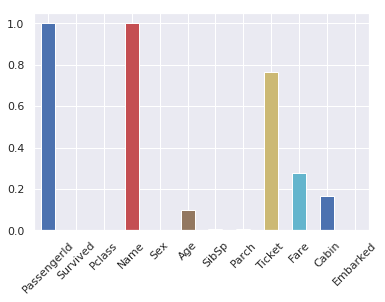

In [8]:
(dfTrain.apply(lambda x:x.unique().shape[0],axis=0)/dfTrain.shape[0]).plot(kind='bar',rot=45)

* 上圖中，若欄位所對應的y值小，則代表該欄位的值有高度重複的現象。也就是說，該欄位可能為類別型變數。而若y值=1,則代表該欄位無重複值，有可能為索引或是連續型變數。

### 看欄位是否有空值？

In [9]:
dfTrain.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

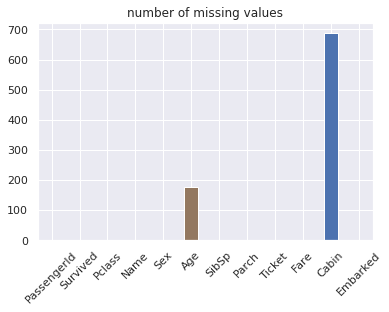

In [10]:
dfTrain.isnull().sum().plot(kind='bar',rot=45,title='number of missing values')

由上圖得知，Age, Cabin和Embarked這三個欄位含有空值。

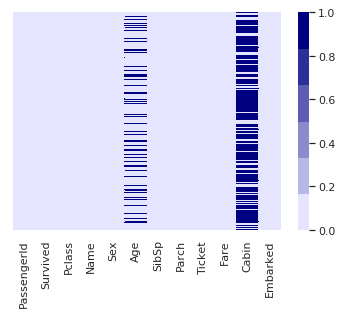

In [11]:
cmap=sns.light_palette("navy", reverse=False)
sns.heatmap(dfTrain.isnull().astype(np.int8),yticklabels=False,cmap=cmap)

### 探究：性別(Sex), 艙等(Pclass)和年齡(Age)，是否會影響生還與否(Survived)？

In [12]:
def trans(x):
    if x<=12:
        return "children"
    elif x>12:
        return "non_children"
    else:
        return np.NaN

dfTrain["AgeInfo"]=dfTrain["Age"].apply(trans)
dfTest["AgeInfo"]=dfTest["Age"].apply(trans)

In [13]:
dfTmp=dfTrain.groupby(["Pclass","Sex"])["Survived"].agg([np.mean,np.std,np.sum,len])
dfTmp=dfTmp.reset_index()
dfTmp

,Pclass,Sex,mean,std,sum,len
0,1,female,0.968085,0.176716,91,94
1,1,male,0.368852,0.484484,45,122
2,2,female,0.921053,0.271448,70,76
3,2,male,0.157407,0.365882,17,108
4,3,female,0.500000,0.501745,72,144
5,3,male,0.135447,0.342694,47,347


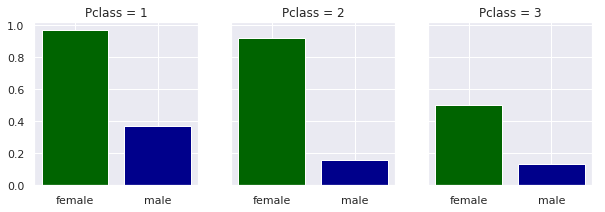

In [14]:
fig,axes=plt.subplots(1,3,figsize=(10,3),sharey=True)
groups=dfTmp.groupby("Pclass")

for idx,(name,group) in enumerate(groups):
    axes[idx].bar(x=group["Sex"],height=group["mean"],
                  color=["darkgreen","darkblue"])
    axes[idx].set_title("Pclass = %i"%name)

* 無論何種艙等，女性生還率皆高於男性至少一倍以上。

利用Seaborn，可簡單的執行一行指令即得到上圖：

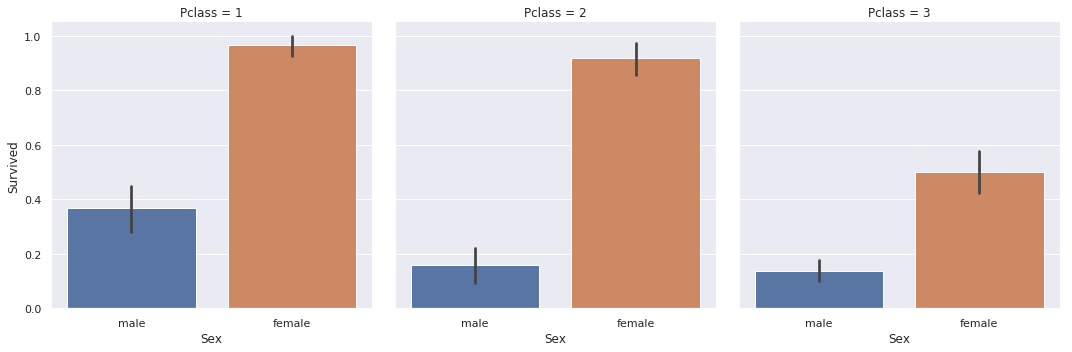

In [15]:
sns.catplot(data=dfTrain,col="Pclass",x="Sex",y="Survived",kind="bar")

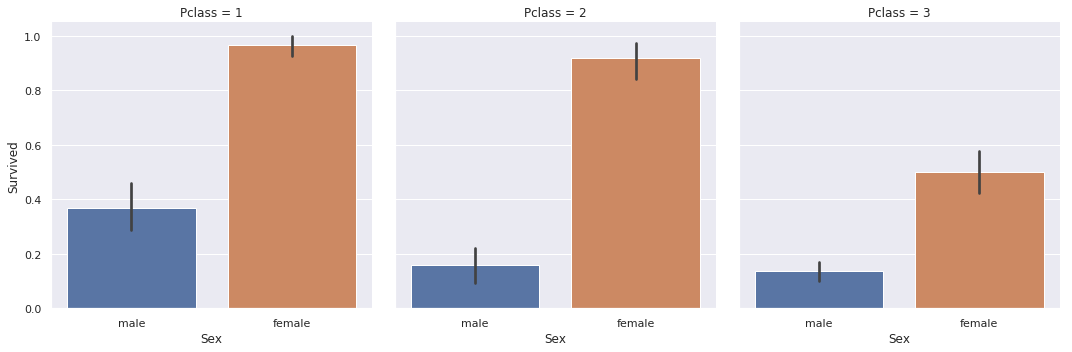

In [16]:
g=sns.catplot(data=dfTrain,col="Pclass",x="Sex",y="Survived",kind="bar")

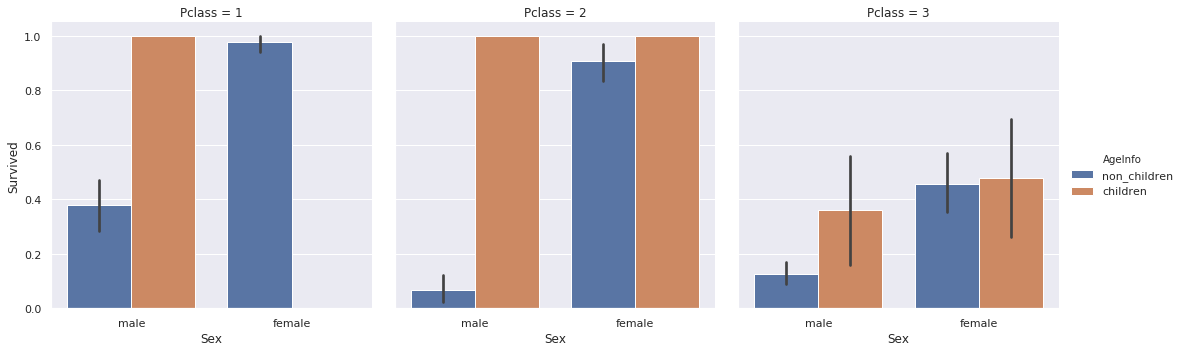

In [17]:
g=sns.catplot(data=dfTrain,col="Pclass",x="Sex",hue="AgeInfo",y="Survived",kind="bar")

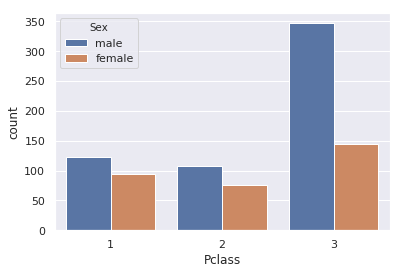

In [18]:
g=sns.countplot("Pclass",hue="Sex",data=dfTrain)

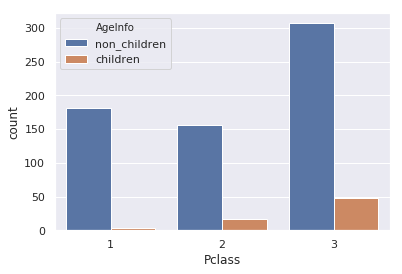

In [19]:
g=sns.countplot("Pclass",hue="AgeInfo",data=dfTrain)

In [20]:
dfTrain["famSize"]=dfTrain["SibSp"]+dfTrain["Parch"]
dfTest["famSize"]=dfTest["SibSp"]+dfTest["Parch"]

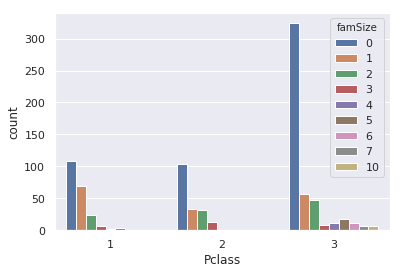

In [21]:
g=sns.countplot("Pclass",hue="famSize",data=dfTrain)

* 三等艙單身的人多，也相較於其他艙等，比較有大一些的家庭。

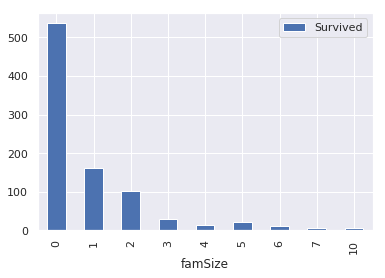

In [22]:
ax=dfTrain[["famSize","Survived"]].groupby("famSize").count().plot(kind="bar")

* 單身一人，沒有家庭的人佔大多數。有超過兩個親人的人不多。

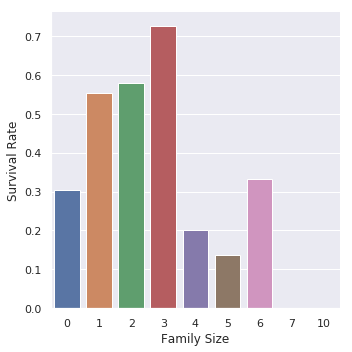

In [23]:
g=sns.catplot(x="famSize",y="Survived",data=dfTrain,kind="bar",ci=None)
g.set_ylabels("Survival Rate")
g.set_xlabels("Family Size")

* 小家庭(1-3人)較容易生還。

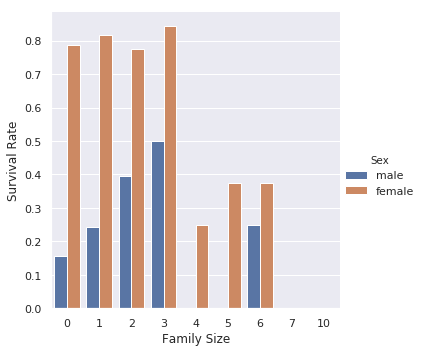

In [24]:
g=sns.catplot(x="famSize",y="Survived",hue='Sex',data=dfTrain,kind="bar",ci=None)
g.set_ylabels("Survival Rate")
g.set_xlabels("Family Size")

* 家室數量$\leq 3$時，男性生還率與家室數量成正比。

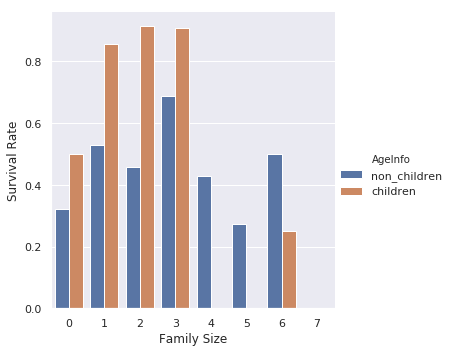

In [25]:
g=sns.catplot(x="famSize",y="Survived",hue='AgeInfo',
                 data=dfTrain[["famSize","Survived","AgeInfo"]].dropna(how="any"),
                 kind="bar",ci=None)
g.set_ylabels("Survival Rate")
g.set_xlabels("Family Size")

* 小孩生還率較非小孩高。

    但家庭太大則不一定。不過，家庭大時，小孩樣本數很少，所以也許沒有參考性。

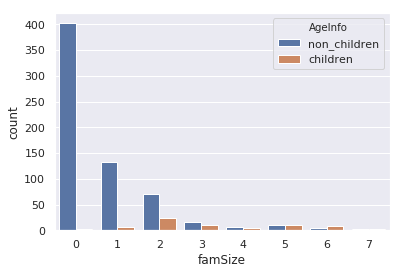

In [26]:
g=sns.countplot("famSize",hue='AgeInfo',
                data=dfTrain[["famSize","AgeInfo"]].dropna(how="any"))

---

### 座位(Cabin)

In [27]:
print("座艙資料筆數=\t", len( dfTrain["Cabin"] ) )
print("座艙空值數=\t",dfTrain["Cabin"].isnull().sum() )

座艙資料筆數=	 891
座艙空值數=	 687


In [28]:
dfTrain["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

座位號碼太多，目前我想要只保留字母。其實也許數字大小也有用，之後或可考慮利用數字大小。

In [29]:
def extractCabinLabel(name):
    try:
        matched=re.search("([A-z])(.*)",name)
        label=matched.groups()[0]
    except:
        label=np.NaN
    return label

dfTrain["Cabin"]=dfTrain["Cabin"].apply(extractCabinLabel)

In [30]:
print( dfTrain["Cabin"].unique()    )
print( dfTrain["Embarked"].unique() )

[nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
['S' 'C' 'Q' nan]


In [31]:
groups=dfTrain[["Cabin","Embarked"] ].groupby("Embarked")
for name,group in groups:
    print(name,group["Cabin"].isnull().sum())

C 99
Q 73
S 515


* 很多從S港口登陸的人，我們不確定他們坐在什麼位置。

### 探究座位(Cabin)是否影響生還與否(Survived)

我們要問的是，是否座位是影響生還率的factor(因子)之一。故，以下使用Seaborn內建的sns.factorplot()來探究:

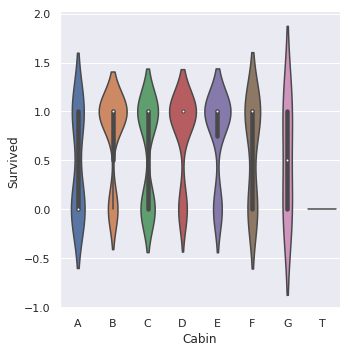

In [32]:
sns.catplot(x="Cabin",y="Survived",data=dfTrain[["Cabin","Survived"]].dropna(how="any"),
               kind="violin",order=["A","B","C","D","E","F","G","T"])

我們直接來計算每個座位區的生存率：

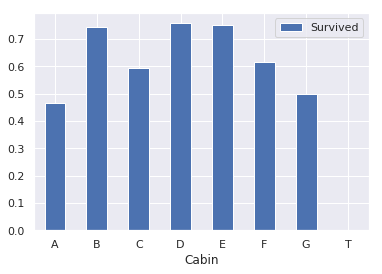

In [33]:
dfTrain[["Cabin","Survived"]].dropna(how="any").groupby("Cabin").mean().plot(kind="bar",rot=0)

/opt/intel/intelpython3/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


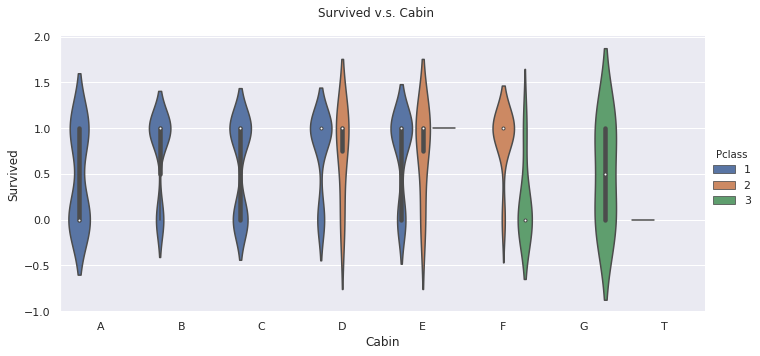

In [34]:
g=sns.catplot(x="Cabin",y="Survived",hue="Pclass",
                 data=dfTrain[["Cabin","Survived","Pclass"]].dropna(how="any"),
                 kind="violin",
                 order=["A","B","C","D","E","F","G","T"],size=5,aspect=2)
g.fig.suptitle("Survived v.s. Cabin")
g.fig.subplots_adjust(top=0.9)

* 由上圖可見，座位順序由A至G移動時，艙等等級隨之下降。

---

### 探究生還與否(Survived)和其他連續變數的相依性(correlation)

In [35]:
corDf=dfTrain.corr()
corDf["Survived"]

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
famSize        0.016639
Name: Survived, dtype: float64

In [36]:
corDf["Survived"].apply(lambda x:np.abs(x)).sort_values(ascending=False)

Survived       1.000000
Pclass         0.338481
Fare           0.257307
Parch          0.081629
Age            0.077221
SibSp          0.035322
famSize        0.016639
PassengerId    0.005007
Name: Survived, dtype: float64

* 由上表可見，連續型變數中，與Survived較為相關的變數有Pclass, Fare。

Correlation可畫成熱圖：

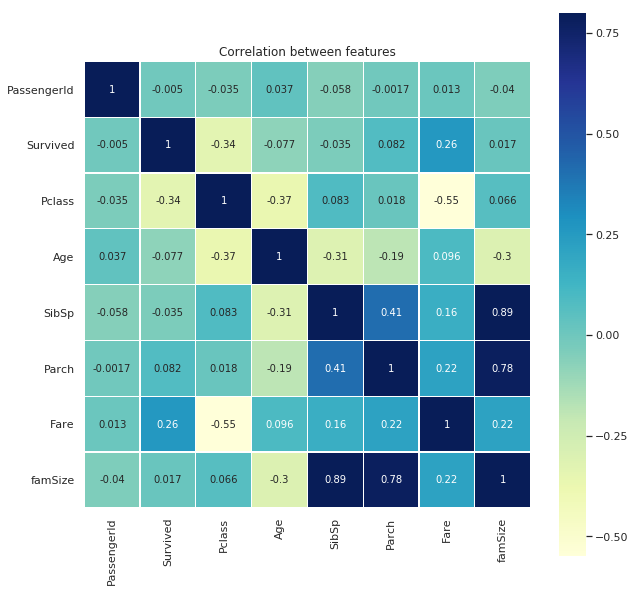

In [37]:
plt.figure(figsize=(10, 10))

g=sns.heatmap(corDf, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

---